In [ ]:
from roboflow import Roboflow

key = ""  # removed from commit for security reasons
rf = Roboflow(api_key=key)
project = rf.workspace("searchandrescue").project("water-segmenter")
dataset = project.version(2).download("png-mask-semantic")

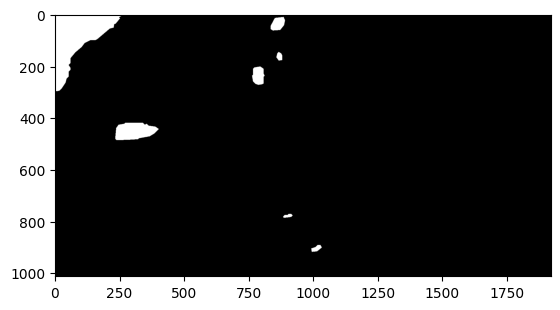

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

SOURCE_IMAGE_PATH = "/home/emilia/msc_ros2/ML/src/Segmentation/Water-segmenter-1/valid/DJI_0804_0013_40m_000875_PNG.rf.ca74ba99115d03ce341aafe7e0b8445d_mask.png"

raw_image = Image.open(SOURCE_IMAGE_PATH)
image_array = np.array(raw_image)
binary_mask = np.where(image_array == 1, 255, 0).astype(np.uint8)

mask_img = Image.fromarray(binary_mask)


plt.imshow(mask_img, cmap="gray")

In [33]:
import os
from PIL import Image, ImageEnhance
from tqdm import tqdm
import cv2
import numpy as np


def refine_mask(mask):
    # Define kernel for morphological operations
    kernel = np.ones((20, 20), np.uint8)

    # Apply morphological operations
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Choose one based on your requirement
    refined_mask = mask_closed
    inverted_mask = cv2.bitwise_not(refined_mask)

    # Return the mask
    return inverted_mask


def process_mask(image_path, save_path):
    image = Image.open(image_path)

    np_image = np.array(image)
    binary_mask = np.where(np_image == 1, 255, 0).astype(np.uint8)
    refined_mask = refine_mask(binary_mask)
    pil_image = Image.fromarray(refined_mask)

    pil_image.save(save_path, format="PNG")


def separate_and_rename_files(source_folder, image_save_folder, mask_save_folder):
    counter = 0

    for filename in tqdm(sorted(os.listdir(source_folder))):
        file_path = os.path.join(source_folder, filename)

        if filename.endswith(".jpg"):  # Process and save image
            new_filename = f"{counter:04d}.png"
            save_path = os.path.join(image_save_folder, new_filename)
            Image.open(file_path).save(save_path)

        elif filename.endswith("_mask.png"):  # Save label
            new_filename = f"{counter:04d}.png"
            save_path = os.path.join(mask_save_folder, new_filename)
            process_mask(file_path, save_path)
            counter += 1


# Base directory for dataset
BASE_DATA_FOLDER = (
    "/home/emilia/msc_ros2/master_ws/src/msc_thesis/offline_utils/train_segmentation"
)

# Folders for original dataset
TEST_DATA_ORIG = f"{BASE_DATA_FOLDER}/Water-segmenter-2/test"
TRAIN_DATA_ORIG = f"{BASE_DATA_FOLDER}/Water-segmenter-2/train"
VALID_DATA_ORIG = f"{BASE_DATA_FOLDER}/Water-segmenter-2/valid"

# Folders for custom dataset
CUSTOM_DATASET_FOLDER = f"{BASE_DATA_FOLDER}/custom_dataset"

TEST_MASK_FOLDER = f"{CUSTOM_DATASET_FOLDER}/test/labels"
TEST_IMAGE_FOLDER = f"{CUSTOM_DATASET_FOLDER}/test/images"

TRAIN_MASK_FOLDER = f"{CUSTOM_DATASET_FOLDER}/train/labels"
TRAIN_IMAGE_FOLDER = f"{CUSTOM_DATASET_FOLDER}/train/images"

VALID_MASK_FOLDER = f"{CUSTOM_DATASET_FOLDER}/valid/labels"
VALID_IMAGE_FOLDER = f"{CUSTOM_DATASET_FOLDER}/valid/images"


separate_and_rename_files(VALID_DATA_ORIG, VALID_IMAGE_FOLDER, VALID_MASK_FOLDER)

100%|██████████| 153/153 [00:11<00:00, 13.22it/s]


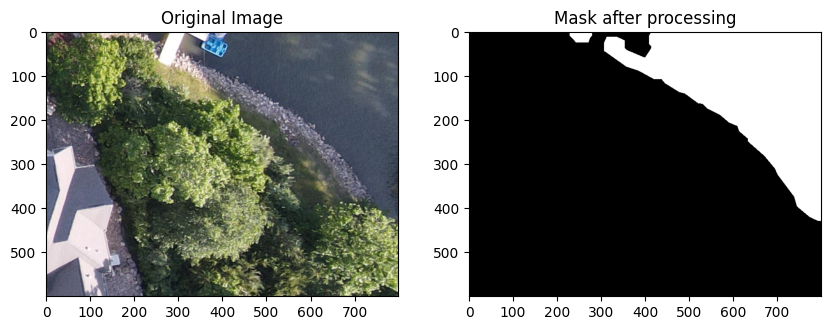

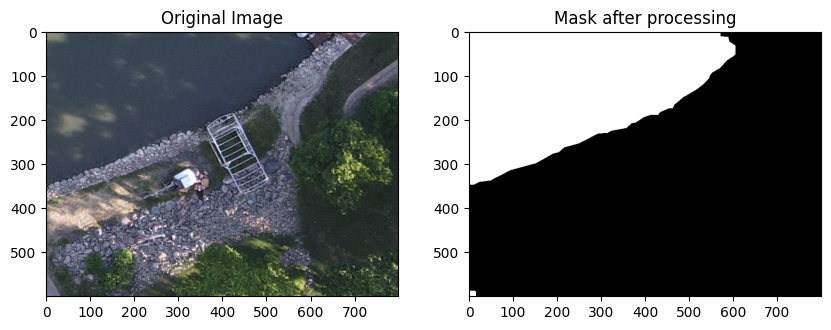

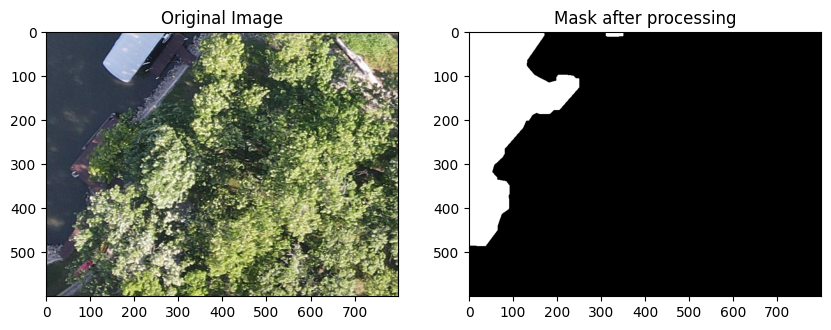

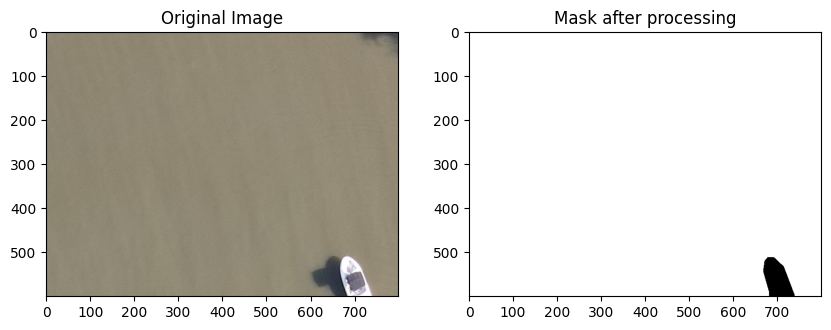

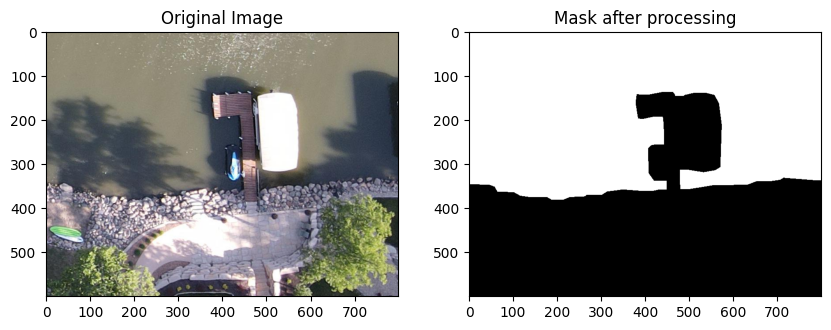

In [31]:
# Refine Masks

import cv2
import numpy as np

from matplotlib import pyplot as plt


for i in range(0, 5):
    image = Image.open(f"{TEST_IMAGE_FOLDER}/{i:04d}.png")
    mask = Image.open
    refined_mask = Image.open(f"{TEST_MASK_FOLDER}/{i:04d}.png")

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    ax[1].imshow(refined_mask, cmap="gray")
    ax[1].set_title("Mask after processing")
    plt.show()